In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from gatspy import datasets

In [2]:
save_path = "chapter2_plots/"
plot_fontsize = 18

## DECam Filter respons

In [3]:
filter_respons = pd.read_csv('data/decam_bands.txt', delim_whitespace=True)

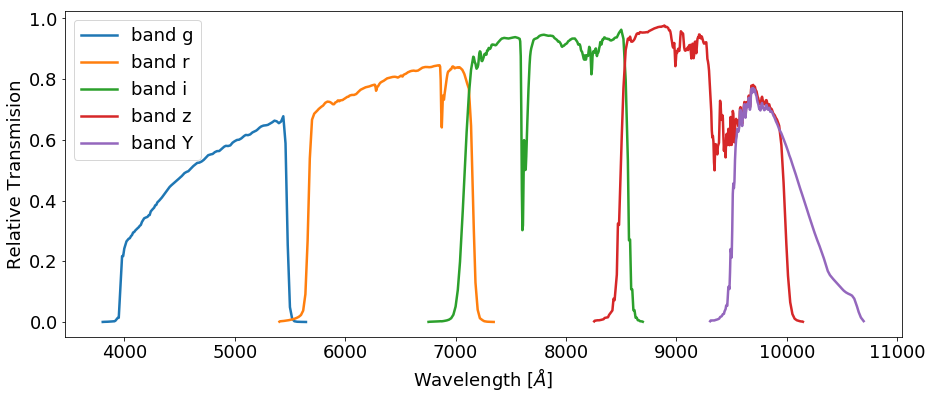

In [4]:
DECam_bands = ['g', 'r', 'i', 'z', 'Y']
wavelength = filter_respons['LAMBDA']
plt.figure(figsize=(15,6))
for i, band in enumerate(DECam_bands):
    non_zero_mask = np.where(filter_respons[band].values > 0)[0]
    plt.plot(wavelength[non_zero_mask], filter_respons[band].values[non_zero_mask], lw=2.5, label="band "+band)
plt.legend(fontsize=plot_fontsize)
plt.tick_params(axis='both', which='major', labelsize=plot_fontsize)
plt.xlabel("Wavelength [$\AA$]", fontsize=plot_fontsize)
plt.ylabel("Relative Transmision", fontsize=plot_fontsize)
plt.savefig(save_path+"filter_respons.pdf")
plt.show()

## Supernova spectra and redshift

In [5]:
def apply_redshift(emited_lambdas, emited_spectra, redshift=0.5):
    observed_lambdas = (1+redshift)*emited_lambdas
    tau = 0.00211*(1+redshift)**(3.7)
    observed_spectra = emited_spectra*np.exp(-tau)# https://academic.oup.com/mnras/article/365/3/807/968285
    return observed_lambdas, observed_spectra

In [6]:
# Data from https://www.nhn.ou.edu/cgi-bin/cgiwrap/~suspect/search.cgi 2006bp
spectra_data = pd.read_csv('data/Quimby_2007_2006bp.txt', delim_whitespace=True)
observerd_wavelength = spectra_data["wavelength"].values
spectra = spectra_data["spectra"].values

In [7]:
## Applying redshift
cmap = matplotlib.cm.get_cmap('plasma')
redshift = [0.0, 0.3, 0.5, 1.0, 1.5, 2.0, 3.0]
colors = np.linspace(start=0, stop=0.75, num=len(redshift))
redshifted_w = []
redshifted_c = []
color_list = []
for i, z in enumerate(redshift):
    redshifted_wavelength, redshifted_spectra = apply_redshift(observerd_wavelength, spectra, redshift=z)
    redshifted_w.append(redshifted_wavelength)
    redshifted_c.append(redshifted_spectra)
    color_list.append(cmap(colors[i]))

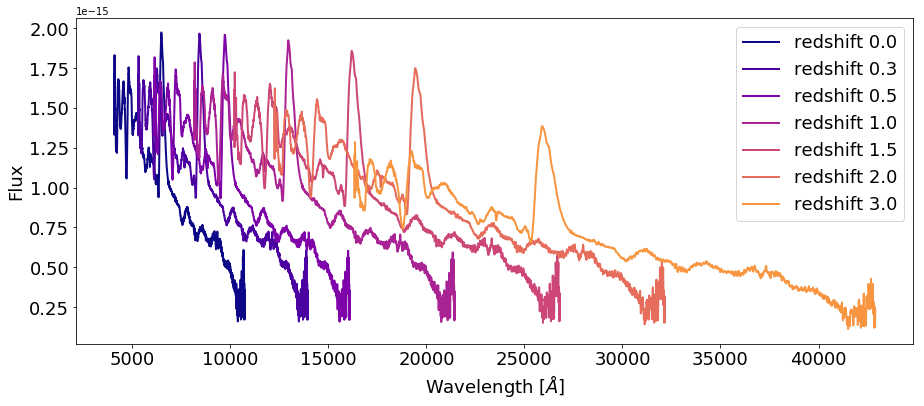

In [8]:
plt.figure(figsize=(15,6))
for i, z in enumerate(redshift):
    plt.plot(redshifted_w[i], redshifted_c[i], color=color_list[i], lw=2, label="redshift "+str(z))
plt.legend(fontsize=plot_fontsize)
plt.tick_params(axis='both', which='major', labelsize=plot_fontsize)
plt.xlabel("Wavelength [$\AA$]", fontsize=plot_fontsize)
plt.ylabel("Flux", fontsize=plot_fontsize)
plt.savefig(save_path+"redshift_effect.pdf")
plt.show()

## Diference Image

In [1]:
# Stamp1, sky1, psf1
# Stamp2, sky2, psf2
# Good aligment
# Dipole

## Periodic light curves plots

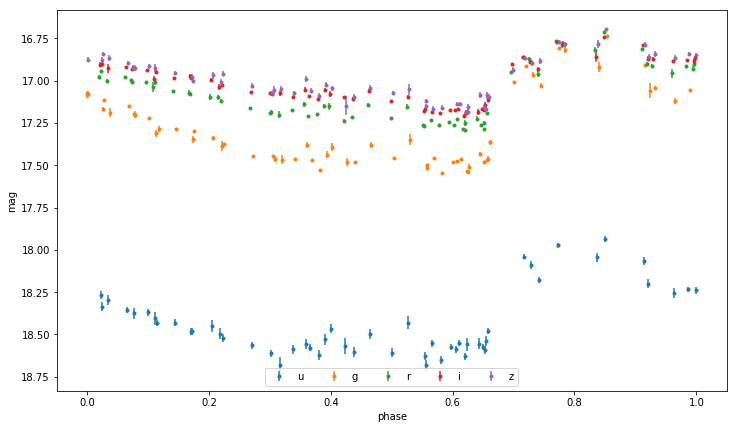

In [10]:
rrlyrae = datasets.fetch_rrlyrae()
lcid = rrlyrae.ids[0]

# Set up the generated lightcurve
gen = datasets.RRLyraeGenerated(lcid, random_state=0)

fig, ax = plt.subplots(figsize=(12,7))
for band in 'ugriz':
    t, mag, dmag = gen.observed(band)
    mag_gen = gen.generated(band, t, dmag)

    period = gen.period
    phase = (t / period) % 1

    errorbar = ax.errorbar(phase, mag, dmag, fmt='.', label=band)
    color = errorbar.lines[0].get_color()
    #ax.plot(phase, mag_gen, 'o', alpha=0.3, color=color, mew=0)

ax.set(xlabel='phase', ylabel='mag')
ax.invert_yaxis()
ax.legend(loc='lower center', ncol=5, numpoints=1)
plt.show()